<a href="https://colab.research.google.com/github/joiakim/deep-learning-study/blob/main/Notebooks/Notes_on_Transfomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import math
import torch.nn.functional as F
import torch.nn as nn

## (1) INPUT EMBEDDINGS



 The Transformer model architecture starts with our inputs converted to inputs embeddings. This can be found at the  section "Embeddings and Softmax",

>  Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension dmodel.
In the embedding layers, we multiply those weights by sqrt(dmodel)


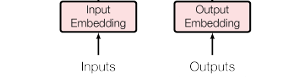




In [ ]:
class InputEmbedding(nn.Module):
  def __init__(self, d_model:int, vocabs:int):
    super().__init__()
    #Dimension of the token's vectors
    self.d_model = d_model
    #Token dictionary
    self.vocabs=vocabs
    #Embedding layer
    self.embedding = nn.Embedding(self.vocabs, self.d_model)

  def forward(self, x):
    '''
    args:
        x: input of shape (batch size,sequence length)
    returns:
        output of (batch size, sequence length, embedding vectors)
    '''
    return self.embedding(x) * math.sqrt(self.d_model)


## (2) POSITIONAL EMBEDDINGS

The next step is to add positional encodings to our input. Think of this adding positional information to our words. As we know word postions do matter in a sentence. This positional info wouldn't undergo learning or training process. Quote attached below from paper.


>  Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.


$$ PE_{(pos,2i)}=sin(\frac{pos}{10000^{\frac{2i}{dmodel}}}) $$
$$ PE_{(pos,2i+1)}=cos(\frac{pos}{10000^{\frac{2i}{dmodel}}}) $$

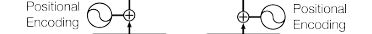



In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, Seq_len:int, d_model:int, dropout:float) -> None:
    super().__init__()
    self.Seq_len = Seq_len
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(Seq_len, d_model)
    position = torch.arange(0, Seq_len, dtype=torch.float).unsqueeze(1)
    pos_denom = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * pos_denom)
    pe[:,1::2] =  torch.cos(position * pos_denom)
    pe = pe.unsqueeze(0)
    self.register_buffer("pe", pe) #buffers- tensors not considered as model parameters


  def forward(self, x):
    '''
    Args:
        x: Input of size(batch, sequence length, embedding dimension)
    output:
          output is the sum of Inputs and Positional encodings values.
    '''
    # (batch, Seq_len, d_model)
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
    #to prevent model on over-relying on positions, some embedding values are zeroed out during training.
    return self.dropout(x)

 supposing our sentence is "That boy is your friend". Then we have 5 words/tokens with different position vectors. The Vectors are added to the embeddings to create a unique vector for each token.

/tmp/ipython-input-2302413374.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave space on right for colorbar


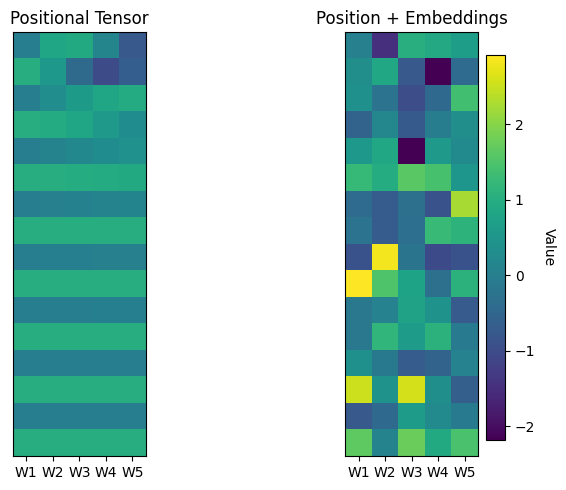

In [6]:
# @title
import torch
import math
import matplotlib.pyplot as plt

#example tensor
example = torch.zeros(5, 16)
positions = torch.arange(0, 5, dtype=torch.float).unsqueeze(1)
pos_deno = torch.exp(torch.arange(0, 16, 2).float() * (-math.log(10000.0) / 16))
example[:, 0::2] = torch.sin(positions * pos_deno)
example[:, 1::2] = torch.cos(positions * pos_deno)

example = example.transpose(1, 0)

# Input embeddings
noise = torch.randn_like(example)
example_plus_noise = example + noise


min_val = min(example.min(), example_plus_noise.min())
max_val = max(example.max(), example_plus_noise.max())


x_labels = ['W1', 'W2', 'W3', 'W4', 'W5']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


im1 = axes[0].imshow(example, vmin=min_val.item(), vmax=max_val.item(),
                     cmap='viridis', aspect='equal')
axes[0].set_xticks(range(len(x_labels)))
axes[0].set_xticklabels(x_labels)
axes[0].set_yticks([])
axes[0].set_title("Positional Tensor")


im2 = axes[1].imshow(example_plus_noise, vmin=min_val.item(), vmax=max_val.item(),
                     cmap='viridis', aspect='equal')
axes[1].set_xticks(range(len(x_labels)))
axes[1].set_xticklabels(x_labels)
axes[1].set_yticks([])
axes[1].set_title("Position + Embeddings")


cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Value', rotation=270, labelpad=15)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()





## (3) ATTENTION MECHANISM

This is the implementation of the attention Mechanism. Where we have the query,key, values. the query-key relation asks and answers what word interacts with which other, the value key tells us the way in which there is a relation.

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^{T}}{\sqrt{d_k}} \right) V
$$

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
$$

where
$$
\text{head}_i = \text{Attention}(Q W^Q_i, \; K W^K_i, \; V W^V_i)
$$

The projections are parameter matrices:
$$
W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}, \quad
W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}, \quad
W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}, \quad
W^O \in \mathbb{R}^{h \cdot d_v \times d_{\text{model}}}.
$$


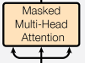


In [ ]:
class MultiHeadAttentionBlock(nn.Module):

  def __init__(self, d_model: int, h: int, dropout: float) -> None:
      super().__init__()
      self.d_model = d_model
      self.h = h # Number of heads
      # Make sure d_model is divisible by h
      assert d_model % h == 0, "Vector Dimension is not divisible by h"

      self.d_k = d_model // h # Dimension of vector seen by each head
      self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
      self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
      self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
      self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
      self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
      d_k = query.shape[-1]
      # Just apply the formula from the paper
      # (batch, h, Seq_len, d_k) --> (batch, h, Seq_len, Seq_len)
      attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
      if mask is not None:
          # Write a very low value (indicating -inf) to the positions where mask == 0
          attention_scores.masked_fill_(mask == 0, -1e9)
      attention_scores = attention_scores.softmax(dim=-1)  # Apply softmax
      if dropout is not None:
          attention_scores = dropout(attention_scores)
      # (batch, h, Seq_len, Seq_len) --> (batch, h, Seq_len, d_k)
      # return attention scores which can be used for visualization
      return (attention_scores @ value), attention_scores

  def forward(self, q, k, v, mask):
      query = self.w_q(q) # (batch, Seq_len, d_model) * (d_model, d_model)
      key = self.w_k(k)
      value = self.w_v(v)

      # (batch, Seq_len, d_model) --> (batch, Seq_len, h, d_k) --> (batch, h, Seq_len, d_k)
      query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
      key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
      value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

      # Calculate attention
      x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

      # Combine all the heads together
      # (batch, h, Seq_len, d_k) --> (batch, Seq_len, h, d_k) --> (batch, Seq_len, d_model)
      x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

      # Multiply by Wo
      # (batch, Seq_len, d_model) --> (batch, Seq_len, d_model)
      return self.w_o(x)

## (4) RESIDUAL CONNECTIONS

This is the the Add and Norm part of our model. For most implementations the normalization of values is pre normalization but the original paper it is a  Add and normalize hinting post normalization.



> We employ a residual connection around each of
 the sub-layers, followed by layer normalization. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x))


Add &norm.PNG

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, eps:float = 10**-6) -> None:
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    mean = x.mean(dim =-1, keepdim=True)
    std = x.std(dim=-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias


In [ ]:
class ResidualConnection(nn.Module):

  def __init__(self, features: int, dropout: float) -> None:
      super().__init__()
      self.dropout = nn.Dropout(dropout)
      self.norm = LayerNormalization(features)

  def forward(self, x, sublayer):
      #From the paper, we do post-normalization against pre-norm
      return self.norm(x + self.dropout(sublayer(x)))

## (5) FEEDFOWARD NETWORK

We implement a feedforward network , a type of Neural Network

$$ FFN(x) = max(0,xW1+b1)W2 +b2 $$


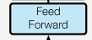

In [ ]:
class FeedForwardNet(nn.Module):

  def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
      super().__init__()
      self.linear_1 = nn.Linear(d_model, d_ff)
      self.dropout = nn.Dropout(dropout)
      self.linear_2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
      # (batch, Seq_len, d_model) --> (batch, Seq_len, d_ff) --> (batch, Seq_len, d_model)
      return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))



## (6) PROJECTION LAYER

This is the projection layer which is a linear layer to project our embedded tokens into tokens. Therefore it changes the dimensionality of the input.

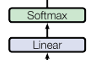

In [ ]:

class ProjectionLayer(nn.Module): #this is the linear layer

  def __init__(self, d_model, vocab_size) -> None:
      super().__init__()
      self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x) -> None:
      # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
      return torch.log_softmax(self.proj(x), dim=-1)


## (7) ENCODER BLOCK

The encoder Block is implemented N times. This is what our encoder Class does for us. As it processes the input, the outpus of the first block is passed as input into the next block. This is done N times.


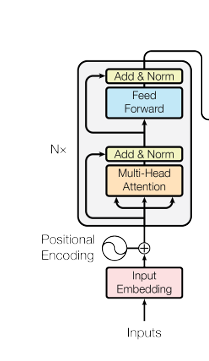

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_Net: FeedForwardNet, dropout: float) -> None:
      super().__init__()
      self.self_attention_block = self_attention_block
      self.feed_forward_Net = feed_forward_Net
      self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)]) # Module list for 2 skip connections.

  def forward(self, x, enc_mask):  #encoder_mask to hide "[pad]" term interaction's with other words.
      x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, enc_mask))
      x = self.residual_connections[1](x, self.feed_forward_Net)
      return x

class Encoder(nn.Module):

  def __init__(self, features: int, layers: nn.ModuleList) -> None:
      super().__init__()
      self.layers = layers
      self.norm = LayerNormalization(features)

  def forward(self, x, mask):
      for layer in self.layers:
          x = layer(x, mask)
      return self.norm(x)

## (8) DECODER BLOCK

The Decoder Block is implemented N times. This is what our Decoder Class does for us. As it processes the input, the outpus of the first block is passed as input into the next block. This is done N times.

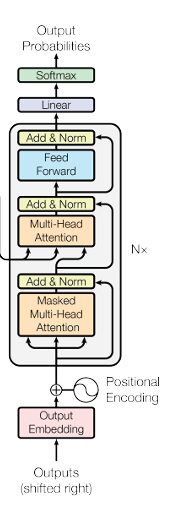

In [ ]:
class DecoderBlock(nn.Module):

  def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_Net: FeedForwardNet, dropout: float) -> None:
      super().__init__()
      self.self_attention_block = self_attention_block
      self.cross_attention_block = cross_attention_block
      self.feed_forward_Net = feed_forward_Net
      self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

  def forward(self, x, encoder_output, enc_mask, dec_mask):
      x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, dec_mask))
      x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, enc_mask))
      x = self.residual_connections[2](x, self.feed_forward_Net)
      return x

class Decoder(nn.Module):

  def __init__(self, features: int, layers: nn.ModuleList) -> None:
      super().__init__()
      self.layers = layers
      self.norm = LayerNormalization(features)

  def forward(self, x, encoder_output, enc_mask, dec_mask):
      for layer in self.layers:
          x = layer(x, encoder_output, enc_mask, dec_mask)
      return self.norm(x)


## (9) FULL ARCHITECTURE

In [2]:

class Transformer(nn.Module):

  def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbedding, tgt_embed: InputEmbedding, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
      super().__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.src_embed = src_embed #inputEmbedding
      self.tgt_embed = tgt_embed #inputEmbedding
      self.src_pos = src_pos   #positionalencoding
      self.tgt_pos = tgt_pos   #positionalencoding
      self.projection_layer = projection_layer

  def encode(self, src, enc_mask):
      # (batch, seq_len, d_model)
      src = self.src_embed(src)
      src = self.src_pos(src)
      return self.encoder(src, enc_mask)

  def decode(self, encoder_output: torch.Tensor, enc_mask: torch.Tensor, tgt: torch.Tensor, dec_mask: torch.Tensor):
      # (batch, seq_len, d_model)
      tgt = self.tgt_embed(tgt)
      tgt = self.tgt_pos(tgt)
      return self.decoder(tgt, encoder_output, enc_mask, dec_mask)

  def project(self, x):
      # (batch, seq_len, vocab_size)
      return self.projection_layer(x)


def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbedding(d_model, src_vocab_size)
    tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardNet(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardNet(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer


References

[Umar Jamil:Coding a Transformer from scratch on pytorch](https://www.youtube.com/watch?v=ISNdQcPhsts&t=18s)

[Attention is all you need](https://arxiv.org/pdf/1706.03762)